<a href="https://colab.research.google.com/github/cbachen1997/CAUstudy/blob/master/ZB_triplet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#挂载谷歌云盘
from google.colab import drive
drive.mount('/content/gdrive')
####google云盘授权#####
##每个notebook执行一次###
__author__='CBA'
# from google.colab import drive

#增加PyDrive操作库
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#授权登录
auth.authenticate_user()
gauth=GoogleAuth()

Mounted at /content/gdrive


In [ ]:
from __future__ import print_function, division
import tensorflow as tf
from sklearn.utils import shuffle
import keras as K
import keras.layers as L
import numpy as np
import os
import time
import h5py
import argparse 
import random
import cv2
from tqdm import *
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import LambdaCallback
# from keras.callbacks import TensorBoard
from keras import regularizers
from tensorflow.keras.models import Model
from __future__ import print_function, division
from keras.layers import *
# from keras.layers import Dense,Dropout
from sklearn.utils import shuffle
from keras.layers.core import Flatten
from keras.utils import to_categorical
# from tensorflow.keras.layers import Conv2D
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
# from keras.layers.core import Lambda
from keras import backend as Kb
from collections import Counter

In [ ]:
#parameter设定
r = 5  # 半径，patch_size = 2*r +1
bachsize = 50
NUM_CLASS = 7
num=20#每类抽10
# alpha=0.05
hchn = 12
ksize = 2 * r + 1
inputshape = (ksize,ksize,hchn)

In [ ]:
X_train = np.load('/content/gdrive/MyDrive/CM/roi_patches/zhangbei_delete_bad_X.npy')
Y_train = np.load('/content/gdrive/MyDrive/CM/roi_patches/zhangbei_delete_bad_Y.npy')
X_val = np.load('/content/gdrive/MyDrive/CM/roi_patches/zb_val_X_r=5.npy')
Y_val = np.load('/content/gdrive/MyDrive/CM/roi_patches/zb_val_Y_r=5.npy')
X_test = np.load('/content/gdrive/MyDrive/CM/roi_patches/zb_test_X_r=5.npy')
Y_test = np.load('/content/gdrive/MyDrive/CM/roi_patches/zb_test_Y_r=5.npy')

In [ ]:
#乱序
permutation = np.random.permutation(X_train.shape[0])    
# print(permutation)    
X_train = X_train[permutation]                                       
Y_train = Y_train[permutation]                                      


In [ ]:
#########################################Machine learning test##############################
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_wine
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

In [ ]:
svc = SVC(kernel='rbf', class_weight='balanced',)
rfc = RandomForestClassifier(n_estimators=250,)
#随机森林86~88%
#SVM 78.1%
#backbone+CE = 93.47%
#backbone+CE+dropout = 93.86%

In [ ]:
X_train = np.reshape(X_train,(1214,-1))


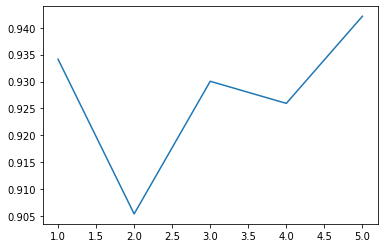

In [ ]:
rfc_s = cross_val_score(rfc,X_train,Y_train,cv=5)
plt.plot(range(1,6),rfc_s,label = "RandomForest")

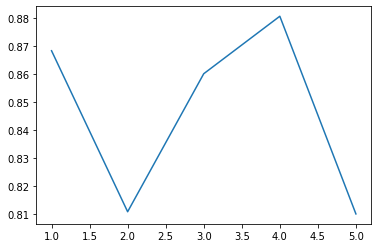

In [ ]:
svc_s = cross_val_score(svc,X_train,Y_train,cv=5)
plt.plot(range(1,6),svc_s,label = "SVM")

In [ ]:
X_test = np.reshape(X_test,(521,-1))

In [ ]:
rfc = rfc.fit(X_train, Y_train)
rfc.score(X_test,Y_test)
rfc.feature_importances_
rfc.apply(X_test)
rfc.predict(X_test)
predict_results=rfc.predict(X_test)

In [ ]:
svc = svc.fit(X_train, Y_train)
svc.score(X_test,Y_test)

svc.predict(X_test)
predict_results=svc.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report
# print(accuracy_score(predict_results, Y_test))
# conf_mat = confusion_matrix(Y_test, predict_results)
# print(conf_mat)
# print(classification_report(Y_test, predict_results))

In [ ]:
from scipy.ndimage.interpolation import map_coordinates as sp_map_coordinates
def tf_flatten(a):
    """Flatten tensor"""
    return tf.reshape(a, [-1])


def tf_repeat(a, repeats, axis=0):
    """TensorFlow version of np.repeat for 1D"""
    # https://github.com/tensorflow/tensorflow/issues/8521
    assert len(a.get_shape()) == 1

    a = tf.expand_dims(a, -1)
    a = tf.tile(a, [1, repeats])
    a = tf_flatten(a)
    return a


def tf_repeat_2d(a, repeats):
    """Tensorflow version of np.repeat for 2D"""

    assert len(a.get_shape()) == 2
    a = tf.expand_dims(a, 0)
    a = tf.tile(a, [repeats, 1, 1])
    return a


def tf_map_coordinates(input, coords, order=1):
    """Tensorflow verion of scipy.ndimage.map_coordinates

    Note that coords is transposed and only 2D is supported

    Parameters
    ----------
    input : tf.Tensor. shape = (s, s)
    coords : tf.Tensor. shape = (n_points, 2)
    """

    assert order == 1

    coords_lt = tf.cast(tf.floor(coords), 'int32')
    #coords_rb = tf.cast(tf.ceil(coords), 'int32')
    coords_rb = tf.cast(tf.math.ceil(coords), 'int32')
    coords_lb = tf.stack([coords_lt[:, 0], coords_rb[:, 1]], axis=1)
    coords_rt = tf.stack([coords_rb[:, 0], coords_lt[:, 1]], axis=1)

    vals_lt = tf.gather_nd(input, coords_lt)
    vals_rb = tf.gather_nd(input, coords_rb)
    vals_lb = tf.gather_nd(input, coords_lb)
    vals_rt = tf.gather_nd(input, coords_rt)

    coords_offset_lt = coords - tf.cast(coords_lt, 'float32')
    vals_t = vals_lt + (vals_rt - vals_lt) * coords_offset_lt[:, 0]
    vals_b = vals_lb + (vals_rb - vals_lb) * coords_offset_lt[:, 0]
    mapped_vals = vals_t + (vals_b - vals_t) * coords_offset_lt[:, 1]

    return mapped_vals


def sp_batch_map_coordinates(inputs, coords):
    """Reference implementation for batch_map_coordinates"""
    coords = coords.clip(0, inputs.shape[1] - 1)
    mapped_vals = np.array([
        sp_map_coordinates(input, coord.T, mode='nearest', order=1)
        for input, coord in zip(inputs, coords)
    ])
    return mapped_vals


def tf_batch_map_coordinates(input, coords, order=1):
    """Batch version of tf_map_coordinates

    Only supports 2D feature maps

    Parameters
    ----------
    input : tf.Tensor. shape = (b, s, s)
    coords : tf.Tensor. shape = (b, n_points, 2)

    Returns
    -------
    tf.Tensor. shape = (b, s, s)
    """

    input_shape = tf.shape(input)
    batch_size = input_shape[0]
    input_size = input_shape[1]
    n_coords = tf.shape(coords)[1]

    coords = tf.clip_by_value(coords, 0, tf.cast(input_size, 'float32') - 1)
    coords_lt = tf.cast(tf.floor(coords), 'int32')
    #coords_rb = tf.cast(tf.ceil(coords), 'int32')
    coords_rb = tf.cast(tf.math.ceil(coords), 'int32')
    coords_lb = tf.stack([coords_lt[..., 0], coords_rb[..., 1]], axis=-1)
    coords_rt = tf.stack([coords_rb[..., 0], coords_lt[..., 1]], axis=-1)

    idx = tf_repeat(tf.range(batch_size), n_coords)

    def _get_vals_by_coords(input, coords):
        indices = tf.stack([
            idx, tf_flatten(coords[..., 0]), tf_flatten(coords[..., 1])
        ], axis=-1)
        vals = tf.gather_nd(input, indices)
        vals = tf.reshape(vals, (batch_size, n_coords))
        return vals

    vals_lt = _get_vals_by_coords(input, coords_lt)
    vals_rb = _get_vals_by_coords(input, coords_rb)
    vals_lb = _get_vals_by_coords(input, coords_lb)
    vals_rt = _get_vals_by_coords(input, coords_rt)

    coords_offset_lt = coords - tf.cast(coords_lt, 'float32')
    vals_t = vals_lt + (vals_rt - vals_lt) * coords_offset_lt[..., 0]
    vals_b = vals_lb + (vals_rb - vals_lb) * coords_offset_lt[..., 0]
    mapped_vals = vals_t + (vals_b - vals_t) * coords_offset_lt[..., 1]

    return mapped_vals


def sp_batch_map_offsets(input, offsets):
    """Reference implementation for tf_batch_map_offsets"""

    batch_size = input.shape[0]
    input_size = input.shape[1]

    offsets = offsets.reshape(batch_size, -1, 2)
    grid = np.stack(np.mgrid[:input_size, :input_size], -1).reshape(-1, 2)
    grid = np.repeat([grid], batch_size, axis=0)
    coords = offsets + grid
    coords = coords.clip(0, input_size - 1)

    mapped_vals = sp_batch_map_coordinates(input, coords)
    return mapped_vals


def tf_batch_map_offsets(input, offsets, order=1):
    """Batch map offsets into input

    Parameters
    ---------
    input : tf.Tensor. shape = (b, s, s)
    offsets: tf.Tensor. shape = (b, s, s, 2)

    Returns
    -------
    tf.Tensor. shape = (b, s, s)
    """

    input_shape = tf.shape(input)
    batch_size = input_shape[0]
    input_size = input_shape[1]

    offsets = tf.reshape(offsets, (batch_size, -1, 2))
    grid = tf.meshgrid(
        tf.range(input_size), tf.range(input_size), indexing='ij'
    )
    grid = tf.stack(grid, axis=-1)
    grid = tf.cast(grid, 'float32')
    grid = tf.reshape(grid, (-1, 2))
    grid = tf_repeat_2d(grid, batch_size)
    coords = offsets + grid

    mapped_vals = tf_batch_map_coordinates(input, coords)
    return mapped_vals

In [ ]:
class ConvOffset2D(Conv2D):
    """ConvOffset2D

    Convolutional layer responsible for learning the 2D offsets and output the
    deformed feature map using bilinear interpolation

    Note that this layer does not perform convolution on the deformed feature
    map. See get_deform_cnn in cnn.py for usage
    """

    def __init__(self, filters, init_normal_stddev=0.01, **kwargs):
        """Init

        Parameters
        ----------
        filters : int
            Number of channel of the input feature map
        init_normal_stddev : float
            Normal kernel initialization
        **kwargs:
            Pass to superclass. See Con2D layer in Keras
        """

        self.filters = filters
        super(ConvOffset2D, self).__init__(
            self.filters * 2, (3, 3), padding='same', use_bias=False,
            kernel_initializer=K.initializers.RandomNormal(0, init_normal_stddev),
            **kwargs
        )

    def call(self, x):
        """Return the deformed featured map"""
        x_shape = x.get_shape()
        offsets = super(ConvOffset2D, self).call(x)

        # offsets: (b*c, h, w, 2)
        offsets = self._to_bc_h_w_2(offsets, x_shape)

        # x: (b*c, h, w)
        x = self._to_bc_h_w(x, x_shape)

        # X_offset: (b*c, h, w)
        x_offset = tf_batch_map_offsets(x, offsets)

        # x_offset: (b, h, w, c)
        x_offset = self._to_b_h_w_c(x_offset, x_shape)

        return x_offset

    def compute_output_shape(self, input_shape):
        """Output shape is the same as input shape

        Because this layer does only the deformation part
        """
        return input_shape

    @staticmethod
    def _to_bc_h_w_2(x, x_shape):
        """(b, h, w, 2c) -> (b*c, h, w, 2)"""
        x = tf.transpose(x, [0, 3, 1, 2])
        x = tf.reshape(x, (-1, int(x_shape[1]), int(x_shape[2]), 2))
        return x

    @staticmethod
    def _to_bc_h_w(x, x_shape):
        """(b, h, w, c) -> (b*c, h, w)"""
        x = tf.transpose(x, [0, 3, 1, 2])
        x = tf.reshape(x, (-1, int(x_shape[1]), int(x_shape[2])))
        return x

    @staticmethod
    def _to_b_h_w_c(x, x_shape):
        """(b*c, h, w) -> (b, h, w, c)"""
        x = tf.reshape(
            x, (-1, int(x_shape[3]), int(x_shape[1]), int(x_shape[2]))
        )
        x = tf.transpose(x, [0, 2, 3, 1])
        return x

In [ ]:
def BN_LeakyReLU(input):
    
    norm = L.BatchNormalization(axis=-1)(input)
    output = L.advanced_activations.LeakyReLU(alpha=0.2)(norm)
    
    return output

In [ ]:
######################################backbone部分######################################
def feature_extraction_CNN(input_shape, n_filters=64):
    # X_input=L.Input(input_shape)
    conv1 = L.Conv2D(n_filters, (3, 3), padding='same', kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(0.0001))(input_shape)
   
    conv1 = BN_LeakyReLU(conv1)
    conv1 = L.Conv2D(2*n_filters, (3, 3), padding='same', kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(0.0001))(conv1)
    conv1 = BN_LeakyReLU(conv1)
    
    pool1 = L.MaxPool2D(pool_size=(2, 2),padding='same')(conv1)
    # print(pool1)
    #可变形block A1
   
    offset_conv2_1 = ConvOffset2D(2*n_filters)(pool1)
   
    conv2_1 = L.Conv2D(n_filters, (3, 3), padding='same', kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(0.0001))(offset_conv2_1)
    conv2_1 = BN_LeakyReLU(conv2_1)
    
    offset_conv2_2 = ConvOffset2D(n_filters)(conv2_1)
    conv2_2 = L.Conv2D(int(0.5*n_filters), (3, 3), padding='same', kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(0.0001))(offset_conv2_2)
    conv2_2 = BN_LeakyReLU(conv2_2)
    
    offset_conv2_3 = ConvOffset2D(int(0.5*n_filters))(conv2_2)
    conv2_3 = L.Conv2D(int(0.5*n_filters), (3, 3), padding='same', kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(0.0001))(offset_conv2_3)
    conv2_3 = BN_LeakyReLU(conv2_3)
    
    conv2_4 = L.concatenate([conv2_1, conv2_2, conv2_3], axis=-1)
    # print(conv2_4)
    conv2_5 = L.merge.add([conv2_4, pool1])

    #可变形block A2
    offset_conv2_6 = ConvOffset2D(2*n_filters)(conv2_5)
    conv2_6 = L.Conv2D(n_filters, (3, 3), padding='same', kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(0.0001))(offset_conv2_6)
    conv2_6 = BN_LeakyReLU(conv2_6)
    
    offset_conv2_7 = ConvOffset2D(n_filters)(conv2_6)
    conv2_7 = L.Conv2D(int(0.5*n_filters), (3, 3), padding='same', kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(0.0001))(offset_conv2_7)
    conv2_7 = BN_LeakyReLU(conv2_7)
    
    offset_conv2_8 = ConvOffset2D(int(0.5*n_filters))(conv2_7)
    conv2_8 = L.Conv2D(int(0.5*n_filters), (3, 3), padding='same', kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(0.0001))(offset_conv2_8)
    conv2_8 = BN_LeakyReLU(conv2_8)
    
    conv2_9 = L.concatenate([conv2_6, conv2_7, conv2_8], axis=-1)
    
    conv2_10 = L.merge.add([conv2_9, conv2_5])
    
    
    #pool2 = L.MaxPool2D(pool_size=(2, 2),padding='same')(conv2_5)
    
    conv3 = L.Conv2D(4*n_filters, (3, 3), padding='valid', strides=(2, 2), kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(0.0001))(conv2_5)
    
    offset_conv3_1 = ConvOffset2D(4*n_filters)(conv3)
    
    conv3_1 = L.Conv2D(2*n_filters, (3, 3), padding='same', kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(0.0001))(offset_conv3_1)
    conv3_1 = BN_LeakyReLU(conv3_1)
    
    offset_conv3_2 = ConvOffset2D(2*n_filters)(conv3_1)
    conv3_2 = L.Conv2D(n_filters, (3, 3), padding='same', kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(0.0001))(offset_conv3_2)
    conv3_2 = BN_LeakyReLU(conv3_2)
    offset_conv3_3 = ConvOffset2D(n_filters)(conv3_2)
    conv3_3 = L.Conv2D(n_filters, (3, 3), padding='same', kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(0.0001))(offset_conv3_3)
    conv3_3 = BN_LeakyReLU(conv3_3)
    
    conv3_4 = L.concatenate([conv3_1, conv3_2, conv3_3], axis=-1)
    
    conv3_5 = L.merge.add([conv3_4, conv3])
 
    #改了一下4*
    offset_conv3_6 = ConvOffset2D(n_filters)(conv3_2)
    
    conv3_6 = L.Conv2D(2*n_filters, (3, 3), padding='same', kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(0.0001))(offset_conv3_6)
    conv3_6 = BN_LeakyReLU(conv3_6)
    
    offset_conv3_7 = ConvOffset2D(2*n_filters)(conv3_6)
    conv3_7 = L.Conv2D(n_filters, (3, 3), padding='same', kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(0.0001))(offset_conv3_7)
    conv3_7 = BN_LeakyReLU(conv3_7)
    
    offset_conv3_8 = ConvOffset2D(n_filters)(conv3_7)
    conv3_8 = L.Conv2D(n_filters, (3, 3), padding='same', kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(0.0001))(offset_conv3_8)
    conv3_8 = BN_LeakyReLU(conv3_8)
    
    conv3_9 = L.concatenate([conv3_6, conv3_7, conv3_8], axis=-1)
    
    conv3_10 = L.merge.add([conv3_9, conv3_5])
    
    
    #pool3 = L.MaxPool2D(pool_size=(2, 2),padding='same')(conv3)
    #输出128维计算度量
    conv4 = L.Conv2D(n_filters*2, (3, 3), padding='same', kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(0.0001))(conv3_10)
    # print(conv4)
    gap = L.GlobalAvgPool2D()(conv4)
    # print(gap)
    #增加功能
    X = Dense(1024,kernel_regularizer=regularizers.l2(0.01),name='dense_layer1')(gap)
    X1 = Dropout(rate=0.5)(X)
    X2 = Dense(256,kernel_regularizer=regularizers.l2(0.01),name='dense_layer2')(X1)
    spatial_result = X2
    print('输出向量维度：' + str(spatial_result.shape))
    return spatial_result
def feature_extraction_CNN_tri(input_shape, n_filters=64):
    X_input=L.Input(input_shape)
    conv1 = L.Conv2D(n_filters, (3, 3), padding='same', kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(0.0001))(X_input)
   
    conv1 = BN_LeakyReLU(conv1)
    conv1 = L.Conv2D(2*n_filters, (3, 3), padding='same', kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(0.0001))(conv1)
    conv1 = BN_LeakyReLU(conv1)
    
    pool1 = L.MaxPool2D(pool_size=(2, 2),padding='same')(conv1)
    # print(pool1)
    #可变形block A1
   
    offset_conv2_1 = ConvOffset2D(2*n_filters)(pool1)
   
    conv2_1 = L.Conv2D(n_filters, (3, 3), padding='same', kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(0.0001))(offset_conv2_1)
    conv2_1 = BN_LeakyReLU(conv2_1)
    
    offset_conv2_2 = ConvOffset2D(n_filters)(conv2_1)
    conv2_2 = L.Conv2D(int(0.5*n_filters), (3, 3), padding='same', kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(0.0001))(offset_conv2_2)
    conv2_2 = BN_LeakyReLU(conv2_2)
    
    offset_conv2_3 = ConvOffset2D(int(0.5*n_filters))(conv2_2)
    conv2_3 = L.Conv2D(int(0.5*n_filters), (3, 3), padding='same', kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(0.0001))(offset_conv2_3)
    conv2_3 = BN_LeakyReLU(conv2_3)
    
    conv2_4 = L.concatenate([conv2_1, conv2_2, conv2_3], axis=-1)
    # print(conv2_4)
    conv2_5 = L.merge.add([conv2_4, pool1])

    #可变形block A2
    offset_conv2_6 = ConvOffset2D(2*n_filters)(conv2_5)
    conv2_6 = L.Conv2D(n_filters, (3, 3), padding='same', kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(0.0001))(offset_conv2_6)
    conv2_6 = BN_LeakyReLU(conv2_6)
    
    offset_conv2_7 = ConvOffset2D(n_filters)(conv2_6)
    conv2_7 = L.Conv2D(int(0.5*n_filters), (3, 3), padding='same', kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(0.0001))(offset_conv2_7)
    conv2_7 = BN_LeakyReLU(conv2_7)
    
    offset_conv2_8 = ConvOffset2D(int(0.5*n_filters))(conv2_7)
    conv2_8 = L.Conv2D(int(0.5*n_filters), (3, 3), padding='same', kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(0.0001))(offset_conv2_8)
    conv2_8 = BN_LeakyReLU(conv2_8)
    
    conv2_9 = L.concatenate([conv2_6, conv2_7, conv2_8], axis=-1)
    
    conv2_10 = L.merge.add([conv2_9, conv2_5])
    
    
    #pool2 = L.MaxPool2D(pool_size=(2, 2),padding='same')(conv2_5)
    
    conv3 = L.Conv2D(4*n_filters, (3, 3), padding='valid', strides=(2, 2), kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(0.0001))(conv2_5)
    
    offset_conv3_1 = ConvOffset2D(4*n_filters)(conv3)
    
    conv3_1 = L.Conv2D(2*n_filters, (3, 3), padding='same', kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(0.0001))(offset_conv3_1)
    conv3_1 = BN_LeakyReLU(conv3_1)
    
    offset_conv3_2 = ConvOffset2D(2*n_filters)(conv3_1)
    conv3_2 = L.Conv2D(n_filters, (3, 3), padding='same', kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(0.0001))(offset_conv3_2)
    conv3_2 = BN_LeakyReLU(conv3_2)
    offset_conv3_3 = ConvOffset2D(n_filters)(conv3_2)
    conv3_3 = L.Conv2D(n_filters, (3, 3), padding='same', kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(0.0001))(offset_conv3_3)
    conv3_3 = BN_LeakyReLU(conv3_3)
    
    conv3_4 = L.concatenate([conv3_1, conv3_2, conv3_3], axis=-1)
    
    conv3_5 = L.merge.add([conv3_4, conv3])
 
    #改了一下4*
    offset_conv3_6 = ConvOffset2D(n_filters)(conv3_2)
    
    conv3_6 = L.Conv2D(2*n_filters, (3, 3), padding='same', kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(0.0001))(offset_conv3_6)
    conv3_6 = BN_LeakyReLU(conv3_6)
    
    offset_conv3_7 = ConvOffset2D(2*n_filters)(conv3_6)
    conv3_7 = L.Conv2D(n_filters, (3, 3), padding='same', kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(0.0001))(offset_conv3_7)
    conv3_7 = BN_LeakyReLU(conv3_7)
    
    offset_conv3_8 = ConvOffset2D(n_filters)(conv3_7)
    conv3_8 = L.Conv2D(n_filters, (3, 3), padding='same', kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(0.0001))(offset_conv3_8)
    conv3_8 = BN_LeakyReLU(conv3_8)
    
    conv3_9 = L.concatenate([conv3_6, conv3_7, conv3_8], axis=-1)
    
    conv3_10 = L.merge.add([conv3_9, conv3_5])
    
    
    #pool3 = L.MaxPool2D(pool_size=(2, 2),padding='same')(conv3)
    #输出128维计算度量
    conv4 = L.Conv2D(n_filters*2, (3, 3), padding='same', kernel_initializer='he_normal',
                    kernel_regularizer=regularizers.l2(0.0001))(conv3_10)
    # print(conv4)
    gap = L.GlobalAvgPool2D()(conv4)
    # print(gap)
    #增加功能
    X = Dense(1024,kernel_regularizer=regularizers.l2(0.01),name='dense_layer1')(gap)
    X1 = Dropout(rate=0.5)(X)
    # X1 = Dense(512,kernel_regularizer=regularizers.l2(0.01),name='dense_layer2')(gap)
    X2 = Dense(256,kernel_regularizer=regularizers.l2(0.01),name='dense_layer3')(X1)
    spatial_result = X2
    print('输出向量维度：' + str(spatial_result.shape))
    model = Model(inputs=X_input,outputs=spatial_result,name='triplet_Model')
    return model
    # return spatial_result

In [ ]:
#用一般交叉熵损失
def logistic_model():
  ksize = 2 * r + 1
  inputshape = L.Input((ksize,ksize,hchn))
  # inputshape = (ksize,ksize,hchn)
  #返回全局平均池化结果
  output_feature = feature_extraction_CNN(inputshape, n_filters=64)
  logits = L.Dense(NUM_CLASS+1, activation = 'softmax')(output_feature)
  model = K.models.Model(inputshape, logits)
  adam = K.optimizers.Adam(lr=1e-5,beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01)
  # adam = K.optimizers.Adam(lr=1e-6)
  model.compile(optimizer = adam, loss = 'categorical_crossentropy', metrics=['acc'])
  
  return model

In [ ]:
#logistic训练
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
def train_logistic(X,Y,X_val,Y_val):
  model = logistic_model()
  X_train, Y_train = shuffle(X, Y)
  model_checkpoint = ModelCheckpoint('/content/gdrive/MyDrive/CM/weight_folder/zhangbei_CE+dropout.h5', monitor='val_loss', verbose=1, 
                                       save_best_only=True, save_weights_only=True,period=10)

  early_stopping =EarlyStopping(monitor='val_loss', patience=10)
  print('a')
  last_model = model.fit(x=X,y=Y,batch_size=50,epochs=100,shuffle=True,validation_data=(X_val, Y_val),
              callbacks=[model_checkpoint, early_stopping])
  # model.save('/content/gdrive/MyDrive/CM/all_crossEntropy.h5')

In [ ]:
Y_train=to_categorical(Y_train)
Y_val=to_categorical(Y_val)

In [ ]:
from collections import Counter
# Counter(Y_test)

In [ ]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(971, 11, 11, 12)
(243, 11, 11, 12)
(521, 11, 11, 12)


In [ ]:
train_logistic(X_train,Y_train,X_val,Y_val)

In [ ]:
########################################精度测试
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, cohen_kappa_score
def get_OA(cm):
    
    total = cm.sum()
    
    diag_arr = np.diagonal(cm, offset=0)
    
    correct = diag_arr.sum()
    
    OA = (correct/total) * 100
    
    return OA

def get_cm_oa_kappa(Y_test, Y_pred,threshold=0.8):
    # pred_y=[]
    # print(threshold)
    # for i in Y_pred:
    #   # print(i[1])
   
    #   if i[1]>=threshold:
    #     temp_y=Y_pred[i]
    #     pred_y.append(temp_y)
    #   else:
    #     temp_y=0
    #     pred_y.append(temp_y)
    # # print(Y_test,Y_pred)
    # # print(pred_y)
    # cm = confusion_matrix(pred_y, Y_test)
    # oa = get_OA(cm)
    # kappa = cohen_kappa_score(pred_y, Y_test)

    ###############################
    Y_pred = np.argmax(Y_pred, axis=1)
    
    Y_test = Y_test.tolist()
    Y_pred = Y_pred.tolist()
    # print(Y_pred)
    # print('\n')
    # print(Y_test)
  
    cm = confusion_matrix(Y_pred, Y_test)
    
    oa = get_OA(cm)
    
    kappa = cohen_kappa_score(Y_pred, Y_test)
    
    # print(cm)
    
    return cm, oa, kappa

def load_npz(npz_path):
    
    npz_arr = np.load(npz_path)
    _files = npz_arr.files
    
    return npz_arr[_files[0]]

In [ ]:
# a=16
# import matplotlib.pyplot as plt
# plt.imshow(X_test[a,:,:,0],cmap='gray')
# print(Y_test[a])

In [ ]:
_weights = '/content/gdrive/MyDrive/CM/weight_folder/zhangbei_CE+dropout.h5'#
model1 = logistic_model()
model1.load_weights(_weights)

输出向量维度：(None, 256)


In [ ]:
Y_pred = model1.predict(X_test, verbose=1)

17/17 [==============================] - 1s 43ms/step


In [ ]:
Y_pred.shape

(521, 8)

In [ ]:
Y_test.shape

In [ ]:
# for i in range(50,90,1):
#   i = float(i/100)
#   cm, oa, kappa = get_cm_oa_kappa(Y_test, Y_pred,threshold=i)
#   print('acc: {:.2f}%  Kappa: {:.4f}'.format(oa,kappa))
#   print('acc: {:2f}%'.format(oa))

In [ ]:
cm, oa, kappa = get_cm_oa_kappa(Y_test, Y_pred)
print('acc: {:.2f}%  Kappa: {:.4f}'.format(oa,kappa))
print('acc: {:2f}%'.format(oa))

[[88  1  1  2  0  0  0]
 [ 0 89  0  0  0  0  0]
 [ 2  0 89  0  8  4  0]
 [ 0  0  0 53  0  1  1]
 [ 0  0  0  0 78  6  1]
 [ 0  0  0  0  4 79  0]
 [ 0  0  0  1  0  0 13]]
acc: 93.86%  Kappa: 0.9267
acc: 93.857965%


In [ ]:
###############################三元组预训练部分###############################
#1 抽取样本
#2 embedding
#3 构建困难三元组
#4 三元组损失
#5 建立模型

In [ ]:
X_train = np.load('/content/gdrive/MyDrive/CM/roi_patches/zb_train_X_r=5.npy')
Y_train = np.load('/content/gdrive/MyDrive/CM/roi_patches/zb_train_Y_r=5.npy')
X_val = np.load('/content/gdrive/MyDrive/CM/roi_patches/zb_val_X_r=5.npy')
Y_val = np.load('/content/gdrive/MyDrive/CM/roi_patches/zb_val_Y_r=5.npy')
X_test = np.load('/content/gdrive/MyDrive/CM/roi_patches/zb_test_X_r=5.npy')
Y_test = np.load('/content/gdrive/MyDrive/CM/roi_patches/zb_test_Y_r=5.npy')

In [ ]:
#1 抽取样本(每类num个)
def sampling(dataset_X,dataset_Y,num):
  X = []
  Y = []
  flag = 0
  for i in range(1,8):#7类
    classes = i
    # print('当前类别为：'+ str(classes))
    current_dataset = dataset_X[dataset_Y == classes]
    #随机抽
    np.random.shuffle(current_dataset)
    random_samples = current_dataset[0:num]
    if flag == 0 :
      random_samples = random_samples.tolist()
      X.append(random_samples)
      Y = Y + [classes for j in range(0,num)]
      X = np.asarray(X[0],dtype=float)
      flag = 1
    else:
      X = np.concatenate((X,random_samples),axis=0)
      Y = Y + [classes for j in range(0,num)]
  print('当前采样集大小:'+str(X.shape))
  Y = np.asarray(Y ,dtype = int)
  return X,Y#Y没啥用
#2 embedding
# def embedding(datanpy,model):
#   length  = datanpy.shape[0]
#   embed_array = np.zeros((datanpy.shape[0],256))
#   for i in range(length):
#     embedding=model.predict_on_batch(datanpy)
#   return embedding
#3 构建困难三元组
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import pdist
def get_hard_triplet(samples_X,samples_Y,model):
  """
  samples:采样结果
  model:模型
  """
  num_ = samples_X.shape[0]
  embed = model.predict(samples_X)
  hard_triplet=np.zeros((num_,3,samples_X.shape[1],samples_X.shape[2],samples_X.shape[3]))
  count = 0 
  print('构建困难三元组ing...')
  for i in range(0,num_):
    classes = samples_Y[i]
    anchor = embed[i,:]
    ##################构建困难正样本##################
    #构建除anchor以外的pos样本
    pos_embed = embed[samples_Y == classes] 
    pos_embed = np.delete(pos_embed,np.where(pos_embed == anchor)[0][0],axis=0)
    #reshape便于计算
    anchor = anchor.reshape((1,-1))
    # hard_pos = samples_X[]
    #计算距离
    anchor = np.repeat(anchor, pos_embed.shape[0], axis=0)
    temp_dis=np.sum((anchor-pos_embed)*(anchor-pos_embed),axis=1)
    loc_p=temp_dis.argmax()#类内最大距离
    hard_pos=samples_X[samples_Y == classes][loc_p,:]#修改
    ##################构建困难负样本##################
    neg_embed = embed[samples_Y != classes]
    anchor = embed[i,:]
    anchor = anchor.reshape((1,-1))
    anchor = np.repeat(anchor, neg_embed.shape[0], axis=0)
    temp_dis=np.sum((anchor-neg_embed)*(anchor-neg_embed),axis=1)
    loc_n=temp_dis.argmin()#类间最小距离
    hard_neg=samples_X[samples_Y != classes][loc_n,:]
    # print("最大距离："+str(loc_p)+"最小距离"+str(loc_n))
    hard_triplet[i,0,:,:,:]=samples_X[i,:,:,:]
    hard_triplet[i,1,:,:,:]=hard_pos
    hard_triplet[i,2,:,:,:]=hard_neg
  return hard_triplet
#3.1 构建困难三元组嵌套
def process_triplet(data_X,label,model,num=num):
  #抽样
  sample_X,sample_Y=sampling(data_X,label,num=num)
  #获取困难三元组
  hard_tri=get_hard_triplet(sample_X,sample_Y,model)
  print('困难三元组构建完成')
  return hard_tri

In [ ]:
X_train = np.delete(X_train,np.where(temp_dis>1),axis=0)
Y_train = np.delete(Y_train,np.where(temp_dis>1),axis=0)

In [ ]:
Counter(Y_train)

Counter({1: 168, 2: 168, 3: 168, 4: 87, 5: 168, 6: 168, 7: 28})

In [ ]:
np.save('/content/gdrive/MyDrive/CM/roi_patches/zhangbei_delete_bad_X.npy', X_train)
np.save('/content/gdrive/MyDrive/CM/roi_patches/zhangbei_delete_bad_Y.npy', Y_train)

In [ ]:
#三元组损失计算
def triplet_loss(triplet,alpha):
  """
  triplet=三元组
  """
  anchor,positive,negative=triplet[0],triplet[1],triplet[2]
  print(anchor.shape)
  #第一步：计算"anchor" 与 "positive"之间编码的距离，这里需要使用axis=-1
  pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)),axis=-1)#二范数，-1代表倒数第一个维度即64
  #第二步：计算"anchor" 与 "negative"之间编码的距离，这里需要使用axis=-1
  neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,negative)),axis=-1)
  #第三步：减去之前的两个距离，然后加上alpha
  basic_loss = tf.add(tf.subtract(pos_dist,neg_dist),alpha)
  #通过取带零的最大值和对训练样本的求和来计算整个公式
  loss = tf.reduce_sum(tf.maximum(basic_loss,0))

  return loss

In [ ]:
def create_train_model(model,alpha):
  y_pred=[]
  anchor_input = Input(inputshape) 
  positive_input = Input(inputshape)
  negative_input = Input(inputshape)
  anchor_out = Model(anchor_input, model(anchor_input))
  positive_out = Model(positive_input, model(positive_input))
  negative_out = Model(negative_input, model(negative_input))
  y_pred.append(anchor_out.output)
  y_pred.append(positive_out.output)
  y_pred.append(negative_out.output)

  loss = Lambda(lambda x: triplet_loss(x, alpha), output_shape=[1],name= 'triplet_loss')(y_pred)
  # y_true=np.zeros((total,3)).tolist() 
  # alpha=0.2
  return Model(inputs = [anchor_input,positive_input,negative_input], outputs=loss)

In [ ]:
def train_model(datanpy_X,label,model,alpha=0):
  # tic = time.clock()
  #抽三元组次数
  num_times=20
  mm = create_train_model(model, alpha)
  # print(model)
  # print(datanpy_X.shape)
  # optm=K.optimizers.Adam(lr=1e-5,beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01)
  optm = K.optimizers.Adam(lr=1e-4,beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01)
  # optm = K.optimizers.RMSprop(lr=1e-4, rho=0.9, epsilon=None,decay=0.01)
  # mm.summary()
  mm.compile(optimizer=optm,loss=lambda t,p:p)
  # model_checkpoint = ModelCheckpoint('/content/gdrive/MyDrive/CM', monitor=None, verbose=1, 
  # print(1)
  model_checkpoint = ModelCheckpoint('/content/gdrive/MyDrive/CM/weight_folder/zhangbei_triplet_weight_alpha=0_2.h5', monitor= 'loss', verbose=1, 
                                     save_best_only=True, save_weights_only=True,period=5) 
  batch_print_callback = LambdaCallback(on_epoch_end=lambda batch,logs: print('验证集精度：'+str(use_val(X_train,Y_train,X_val,Y_val,model))))
  early_stopping =EarlyStopping(monitor='loss', patience=5)
  for i in tqdm(range(num_times)):
    hard_tri=process_triplet(datanpy_X,label,model,num=25)#超参数,抽取的三元组个数
    y_label=np.zeros((len(hard_tri),1))#y用不着
    xx = [
          hard_tri[:,0,:,:,:],
          hard_tri[:,1,:,:,:],
          hard_tri[:,2,:,:,:]
    ]
    # model.load_weights('/content/gdrive/MyDrive/CM/new_CNN_weight.h5')
    mm.fit(x=xx,y=y_label,batch_size=25,epochs=50,shuffle=True,callbacks=[model_checkpoint, early_stopping, batch_print_callback])
    # model.save('/content/gdrive/MyDrive/CM/weight_folder/new_dataset_triplet_weight_alpha0.3.h5')

In [ ]:
def use_val(train_X,train_Y,val_X,val_Y,model):
  pred = test_predict(train_X,train_Y,val_X,model)
  pred = to_categorical(pred)
  cm,oa,kappa = get_cm_oa_kappa(val_Y,pred)
  return oa

In [ ]:
############################################
Smodel = feature_extraction_CNN_tri(inputshape,n_filters=64)

输出向量维度：(None, 256)


In [ ]:
train_model(X_train,Y_train,Smodel,alpha=0)

In [ ]:
def test_predict(train_X,train_Y,test_X,model):
  train_X_embed = model.predict(train_X)
  test_X_embed = model.predict(test_X)
  pred_class = []
  for i in range(0,test_X_embed.shape[0]):
    #计算到各个类别的距离
    dist_mat = tf.reduce_sum(tf.square(tf.subtract(test_X_embed[i],train_X_embed)),axis=-1)
    index = int(np.where(dist_mat == np.min(dist_mat))[0])
    classes = Y_train[index]
    pred_class.append(classes)
  return pred_class


In [ ]:
######################################测试集测试预训练模型
Tmodel=feature_extraction_CNN_tri(inputshape)
weight_ = '/content/gdrive/MyDrive/CM/weight_folder/zhangbei_triplet_weight_alpha=0.h5'
Tmodel.load_weights(weight_,by_name=True)

#/content/gdrive/MyDrive/CM/weight_folder/zhangbei_triplet_weight_RMSprop_alpha=1.h5   76%
#/content/gdrive/MyDrive/CM/weight_folder/zhangbei_triplet_weight_RMSprop_alpha=0.h5   81.77%
#/content/gdrive/MyDrive/CM/weight_folder/zhangbei_triplet_weight_alpha=0.h5       82.15%
#/content/gdrive/MyDrive/CM/weight_folder/zhangbei_triplet_weight_alpha=0.5.h5      79.65%
#/content/gdrive/MyDrive/CM/weight_folder/zhangbei_triplet_weight_Nodropout_alpha=0.2.h5 78.89%
#'/content/gdrive/MyDrive/CM/weight_folder/zhangbei_triplet_weight_Nodropout_alpha=0.h5' 78%
#‘/content/gdrive/MyDrive/CM/weight_folder/zhangbei_triplet_weight_alpha=0_2.h5'    

输出向量维度：(None, 256)


In [ ]:
pred = test_predict(X_train,Y_train,X_test,Tmodel)

In [ ]:
pred1 = to_categorical(pred)

In [ ]:
cm, oa, kappa = get_cm_oa_kappa(Y_test, pred1)
print('acc: {:.2f}%  Kappa: {:.4f}'.format(oa,kappa))
print('acc: {:2f}%'.format(oa))

acc: 78.89%  Kappa: 0.7477
acc: 78.886756%
